<a href="https://colab.research.google.com/github/bsalami-092/Blessing-ML-Zoomcamp-2025/blob/main/ML_Zoomcamp_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

In [ ]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [ ]:
!wget $data

--2025-10-28 14:39:04--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.3’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-28 14:39:04 (7.43 MB/s) - ‘course_lead_scoring.csv.3’ saved [80876/80876]



In [ ]:
df = pd.read_csv(data)

df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [ ]:
cat_var = list(df.dtypes[df.dtypes == 'object'].index)

cat_var

['lead_source', 'industry', 'employment_status', 'location']

In [ ]:
num_var = list(df.dtypes[df.dtypes != 'object'].index)

num_var

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [ ]:
 df.isna().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [ ]:
for i in cat_var:
  df[i] = df[i].fillna('NA')

In [ ]:
for z in num_var:
  df[z] = df[z].fillna(0)

In [ ]:
df.isna().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [ ]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

**Question 1: ROC AUC feature importance**
* ROC AUC could also be used to evaluate feature importance of numerical variables.

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that
* If your AUC is < 0.5, invert this variable by putting "-" in front

* (e.g. -df_train['balance'])

* AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

* Which numerical variable (among the following 4) has the highest AUC?

* lead_score
* number_of_courses_viewed
* interaction_count
* annual_income

In [ ]:
auc_score = {}

for i in ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']:
    auc = roc_auc_score(df_train_full['converted'], df_train_full[i])

    if auc < 0.5:
      auc = roc_auc_score(df_train_full['converted'], -df_train_full[i])

    auc_score[i] = auc

auc_score = {k: float(v) for k, v in auc_score.items()}.items()
auc_score = sorted(auc_score, key=lambda x: x[1], reverse=True)

In [ ]:
auc_score

[('number_of_courses_viewed', 0.7578540402328948),
 ('interaction_count', 0.7276793690890606),
 ('lead_score', 0.6163611718677798),
 ('annual_income', 0.5533332306460059)]

**Question 2: Training the model**
* Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* What's the AUC of this model on the validation dataset? (round to 3 digits)

In [ ]:
num_var.remove('converted')

In [ ]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat_var + num_var].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [ ]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
val_dict = df_val[cat_var + num_var].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [ ]:
yval_preds = model.predict(X_val)

In [ ]:
auc = roc_auc_score(y_val, yval_preds)

round(float(auc), 3)

0.648

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, yval_preds)

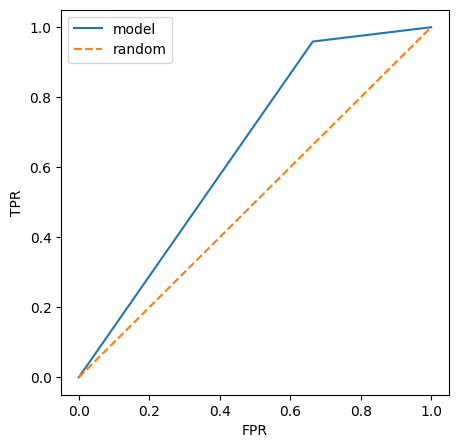

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

**Question 3: Precision and Recall**
* Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall

* Plot them at which threshold precision and recall curves intersect?

In [ ]:
np.arange(0, 11, 0.01)

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.097e+01, 1.098e+01,
       1.099e+01])

In [ ]:
model = LogisticRegression(solver='liblinear', C=1, max_iter=1000)
model.fit(X_train, y_train)
yval_probs = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions, recalls = [], []

for t in thresholds:
    yval_preds = (yval_probs >= t).astype(int)
    precisions.append(precision_score(y_val, yval_preds))
    recalls.append(recall_score(y_val, yval_preds))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


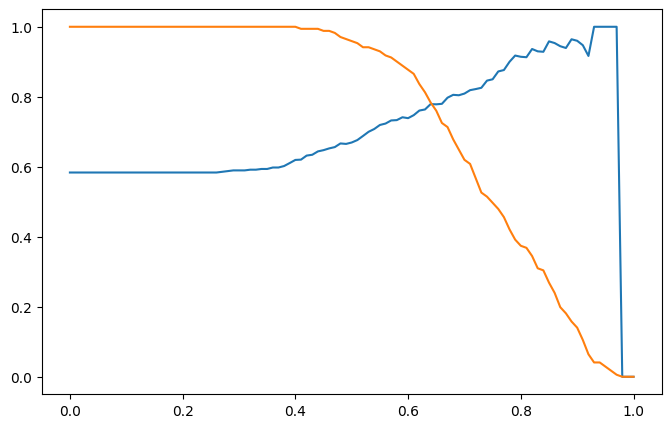

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')



In [ ]:
diff = np.abs(np.array(precisions) - np.array(recalls))

np.where(diff < 0.01)

(array([ 64,  98,  99, 100]),)

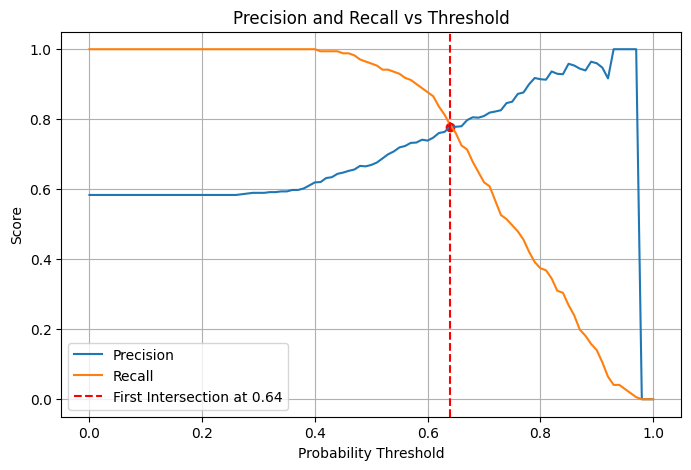

Lowest intersection threshold = 0.64
Precision = 0.779, Recall = 0.784


In [ ]:
# We can see that the curves intercepted more than once
diff = np.abs(np.array(precisions) - np.array(recalls))
close_points = np.where(diff < 0.01)[0]

if len(close_points) > 0:
    idx = close_points[0]
else:
    idx = np.argmin(diff)

best_threshold = thresholds[idx]


plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'First Intersection at {best_threshold:.2f}')
plt.scatter(best_threshold, precisions[idx], color='red')

plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

print(f"Lowest intersection threshold = {best_threshold:.2f}")
print(f"Precision = {precisions[idx]:.3f}, Recall = {recalls[idx]:.3f}")



### Question 4: F₁ score

Precision and recall are often in conflict — when one grows, the other tends to go down.  
To balance both we use the **F₁ score**, the harmonic mean of precision (**P**) and recall (**R**):

$$
F_1 = \frac{2 \cdot P \cdot R}{P + R}
$$

Where:  
- **P** = Precision  
- **R** = Recall  

Compute **F₁** for all thresholds from **0.00** to **1.00** (step **0.01**).  
Which threshold gives the **maximum F₁**?


In [ ]:
model = LogisticRegression(solver='liblinear', C=1, max_iter=1000)
model.fit(X_train, y_train)
yval_probs = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions, recalls, f1 = [], [], []

for t in thresholds:
    yval_preds = (yval_probs >= t).astype(int)
    precision = precision_score(y_val, yval_preds)
    recall = recall_score(y_val, yval_preds)
    precisions.append(precision)
    recalls.append(recall)
    if (precision + recall) == 0:
        f1.append(0)
    else:
        f1.append(2 * (precision * recall) / (precision + recall))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
f1_scores = np.array(f1)
idx = np.argmax(f1_scores)
best_threshold = thresholds[idx]
best_f1 = f1_scores[idx]

print(f"Best threshold: {best_threshold:.2f}, Best F1: {best_f1:.3f}")


Best threshold: 0.57, Best F1: 0.812


### 🧠 Question 5: 5-Fold Cross-Validation

Use the **KFold** class from **Scikit-Learn** to evaluate our model on 5 different folds.

- Use the following parameters for KFold:  
  `KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of `df_full_train`
- Split the data into **train** and **validation** sets
- Train the model on the train set using:  
  `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use **AUC (Area Under the Curve)** to evaluate the model on the validation set

**Question:**  
👉 How large is the **standard deviation** of the AUC scores across the different folds?


In [ ]:
n_splits = 5

scores = []

kfold =KFold(n_splits=n_splits, shuffle=True, random_state=1)


for train_idx, val_idx in tqdm(kfold.split(df_train_full), total = n_splits):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values


    dv = DictVectorizer(sparse=False)
    train_dict = df_train[cat_var + num_var].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dict = df_val[cat_var + num_var].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    yval_preds = model.predict_proba(X_val)[:, 1]


    auc = roc_auc_score(y_val, yval_preds)
    scores.append(auc)

    print("Mean AUC: %.3f ± %.3f" % (np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

Mean AUC: 0.806 ± 0.000
Mean AUC: 0.839 ± 0.033
Mean AUC: 0.818 ± 0.040
Mean AUC: 0.814 ± 0.035
Mean AUC: 0.822 ± 0.036


### ⚙️ Question 6: Hyperparameter Tuning

Now let's use **5-Fold Cross-Validation** to find the best parameter **C**.

- Iterate over the following values of **C**:  
  `[0.000001, 0.001, 1]`
- Initialize **KFold** with the same parameters as before:  
  `KFold(n_splits=5, shuffle=True, random_state=1)`
- Use these parameters for the model:  
  `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- For each value of **C**, compute:
  - The **mean AUC score** across all folds  
  - The **standard deviation** of the AUC scores  

(👉 Round both the mean and standard deviation to **3 decimal digits**.)

**Question:**  
Which value of **C** gives the **best mean AUC score**?


In [ ]:
n_splits = 5

results = []

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in tqdm(kfold.split(df_train_full), total=n_splits):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv = DictVectorizer(sparse=False)
        train_dict = df_train[cat_var + num_var].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_val[cat_var + num_var].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        yval_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, yval_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    print(f'C={C}  {mean_auc:.3f} ± {std_auc:.3f}')
    results.append({'C': C, 'mean_auc': round(mean_auc, 3), 'std_auc': round(std_auc, 3)})

results


  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06  0.560 ± 0.024


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001  0.867 ± 0.029


  0%|          | 0/5 [00:00<?, ?it/s]

C=1  0.822 ± 0.036


[{'C': 1e-06, 'mean_auc': np.float64(0.56), 'std_auc': np.float64(0.024)},
 {'C': 0.001, 'mean_auc': np.float64(0.867), 'std_auc': np.float64(0.029)},
 {'C': 1, 'mean_auc': np.float64(0.822), 'std_auc': np.float64(0.036)}]